In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from portfolio import Portfolio, plot_transaction_history
import matplotlib.pyplot as plt

from files import read_stock_files, write_transaction_file
from trade import Trader

Διαβάζουμε όλα τα αρχεία από το directory /Stocks και συγκεντρώνουμε όλα τα δεδομένα σε ένα μεγάλο dataframe, με στήλες το όνομα της μετοχής, την ημερομηνία και τα υπόλοιπα δεδομένα των .txt αρχείων. 

In [2]:
stocks_df = read_stock_files('../Stocks')

  0%|          | 0/7195 [00:00<?, ?it/s]

100%|██████████| 7195/7195 [00:16<00:00, 439.64it/s]


Αγνοούμε όλες τις μετοχές που έχουν συνολικά λιγότερες γραμμές από 252, που αντιστοιχούν σε 1 έτος συναλλαγών. Επίσης, αγνούμε τις δυάδες (μετοχή, ημερομηνία) που δεν πληρούν κάποιους βασικούς ελέγχους όπως:
- Οι τιμές των στηλών "Low", "High", "Open", "Close", "Volume" πρέπει να είναι όλες θετικές.
- Οι τιμές "High" πρέπει να είναι μεγαλύτερες από τις αντίστοιχες "Low".
- Οι τιμές "High" δεν είναι μεγαλύτερες από το δεκαπλάσιο του "Low".
- Οι τιμές "Volume" είναι τουλάχιστον 10

Τέλος αφαιρούμε τη στήλη "OpenInt" και θέτουμε ως index στο dataframe τις στήλες "Date", "Name" για γρήγορες αναζητήσεις με βάσει αυτές.

In [3]:
# drop stocks with less than a year of data
stocks_df = stocks_df.groupby('Name').filter(lambda x: len(x) >= 252)

# drop rows
stocks_df.drop(
    index=stocks_df.loc[
        (stocks_df[["Low", "High", "Open", "Close", "Volume"]] <= 0).any(axis=1) | 
        (stocks_df['Low'] > stocks_df['High']) | 
        (stocks_df['Volume'] < 10) | 
        (stocks_df['High'] > 10 * stocks_df['Low'])
    ].index,
    inplace=True,
)
stocks_df.drop(columns=["OpenInt"], inplace=True)
stocks_df.set_index(["Date", "Name"], inplace=True)


Επιλέγουμε να κρατήσουμε τις 50 μετοχές με τη μεγαλύτερη ποσοστιαία αύξηση στη διάρκεια ζωής τους (stonks). 

Η βασική λογική που θα ακολουθήσουμε είναι συνεχώς να αγοράζουμε μετοχές όσο είναι κοντά στο ελάχιστό τους, να τις αφήνουμε να παίρνουν αξία και να τις πουλάμε κοντά στο μέγιστό τους. Στο ενδιάμεσο, για να βγάλουμε λεφτά, πουλάμε όσες μετοχές μπορούμε στο υψηλό της ημέρας και τις αγοράζουμε όλες πίσω στο χαμηλό της ημέρας, αρκεί το υψηλό να συμπίπτει με το άνοιγμα της μέρας ή το χαμηλό να συμπίπτει με το κλείσιμο. 

Επειδή σκοπός μας είναι η μεγιστοποίηση των χρημάτων στο τέλος του ορίζοντα, αρχίζουμε να ξεπουλάμε μετοχές όταν έχουμε στη κατοχή μας περισσότερες από όσες μπορούμε να πουλήσουμε. 

Εκτός από τα παραπάνω συμπεριλαμβάνουμε στη λίστα των μετοχών και την 'ge' καθώς ξεκινάει από την αρχή του χρονικού ορίζοντα.

In [4]:
grouped_by_stock = stocks_df.groupby("Name")

dff = pd.DataFrame({
    "HighClose": grouped_by_stock['Close'].max(),
    "DateHighClose": grouped_by_stock['Close'].idxmax().apply(lambda i: i[0]),
    "LowClose": grouped_by_stock['Close'].min(),
    "DateLowClose": grouped_by_stock['Close'].idxmin().apply(lambda i: i[0]),
})
dff['Diff'] = (dff['HighClose'] - dff['LowClose'])/dff['LowClose']
dff = dff.loc[dff['DateHighClose'] > dff['DateLowClose']]
stonks_names = list(dff.sort_values(by='Diff', ascending=False).head(50).index)
stonks_names.append('ge')

Ταξινομούμε το dataframe με τις μετοχές που επιλεξαμε με βάσει την ημερομηνία σε αύξουσα σειρά.

In [5]:
# keep only stonks
stocks_df = stocks_df.loc[pd.IndexSlice[:, stonks_names], :].copy()
stocks_df.sort_index(level="Date", ascending=True, inplace=True)

Για κάθε μετοχή, υπολογίζουμε το μέγιστο κλείσιμο και το ελάχιστο κλείσιμο καθώς και τις ημερομηνίες που αυτά επετεύχθησαν. Η πληροφορία αυτή κρατιέται στο επίπεδο της (μετοχής, μέρας) για εύκολη πρόσβαση σε αυτή. Επίσης για κάθε μετοχομέρα κρατάμε το ποσοστό αύξησης από την ελάχιστη τιμή της στη στήλη "PercentageIncrease".

In [6]:
stocks_df['AllTimeMaxClose'] = stocks_df.groupby('Name')['Close'].transform('max')
stocks_df['AllTimeMinClose'] = stocks_df.groupby('Name')['Close'].transform('min')
stocks_df['AllTimeMaxCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmax().map(lambda x: x[0])
)
stocks_df['AllTimeMinCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmin().map(lambda x: x[0])
)
stocks_df['PercentageIncrease'] = (stocks_df['Close'] - stocks_df['AllTimeMinClose'])/(stocks_df['AllTimeMaxClose'] - stocks_df['AllTimeMinClose'])


Για κάθε μετοχομέρα υπολογίζουμε το κάτα πόσο θέλουμε να αγοράσουμε τη συγκεκριμένη μετοχή τη συγκεκριμένη μέρα "WantToBuy" και το κατα πόσο θέλουμε να τη πουλήσουμε "WantToSell". Γενικά:
- Θέλουμε να αγοράζουμε μια μετοχή όταν βρίσκεται κάτω από το 5% της μεγιστης αύξησής της
- Θέλουμε να πουλήσουμε μια μετοχή όταν βρίσκεται πάνω από το 50% της μεγιστης αύξησής της

Όλες οι μετοχές μας είναι stonks οπότε σε κάποια φάση της ζωής τους ανεβαίνουν απότομα. Κάποιες όμως αρχίζουν να κατρακυλούν μετά το peak τους. Όταν πιάσουν το μέγιστο τους και έπειτα προφανώς θέλουμε μόνο να πουλάμε.

In [7]:
stocks_df['WantToSell'] = 0
stocks_df['WantToBuy'] = 0

stocks_df['PercentageIncrease'] = (stocks_df['Close'] - stocks_df['AllTimeMinClose'])/(stocks_df['AllTimeMaxClose'] - stocks_df['AllTimeMinClose'])
stocks_df.loc[stocks_df['PercentageIncrease'] > 0.5, 'WantToSell'] = 1
stocks_df.loc[stocks_df['PercentageIncrease'] < 0.05, 'WantToBuy'] = 1

stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToSell'] = 1
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToSell'] = 0

Υπολογίζουμε το πόσες μετοχές μπορούμε να πουλήσουμε, αν μόνο πουλάμε, από μια μετοχομέρα έως το τέλος του ορίζοντα. Το μέτρο αυτό είναι χρήσιμο, ώστε να ξέρουμε πότε πρέπει να αρχίζουμε να πουλάμε μαζικά μια μετοχή.

In [8]:
stocks_df["MaxCanSellUntilEnd"] = 0.1 * stocks_df[::-1].groupby("Name")['Volume'].cumsum()[::-1]

Το τελικό dataframe περιλαμβάνει 384693 μετοχομέρες.

In [9]:
stocks_df

Open      High       Low     Close   Volume  \
Date       Name                                                    
1962-01-02 ge      0.6277    0.6362    0.6201    0.6201  2575579   
1962-01-03 ge      0.6201    0.6201    0.6122    0.6201  1764749   
1962-01-04 ge      0.6201    0.6201    0.6037    0.6122  2194010   
1962-01-05 ge      0.6122    0.6122    0.5798    0.5957  3255244   
1962-01-08 ge      0.5957    0.5957    0.5716    0.5957  3696430   
...                   ...       ...       ...       ...      ...   
2017-11-10 unh   211.4600  211.8100  210.2000  211.0700  1384718   
           utx   118.0000  118.4800  118.0000  118.1100  3122513   
           uve    25.2500   25.4500   24.9500   25.2500   256504   
           viav    8.4000    8.6100    8.3400    8.5500  5418048   
           wmt    90.2400   91.6900   90.2000   90.9200  7646013   

                 AllTimeMaxClose  AllTimeMinClose AllTimeMaxCloseDate  \
Date       Name                                                         
1962-01-02 ge             48.056          0.45902          2000-08-28   
1962-01-03 ge             48.056          0.45902          2000-08-28   
1962-01-04 ge             48.056          0.45902          2000-08-28   
1962-01-05 ge             48.056          0.45902          2000-08-28   
1962-01-08 ge             48.056          0.45902          2000-08-28   
...                          ...              ...                 ...   
2017-11-10 unh           212.870          0.26126          2017-11-03   
           utx           122.960          0.20553          2017-07-12   
           uve            34.076          0.02781          2015-10-23   
           viav          666.460          1.00060          2000-03-06   
           wmt            90.920          0.00821          2017-11-10   

                AllTimeMinCloseDate  PercentageIncrease  WantToSell  \
Date       Name                                                       
1962-01-02 ge            1962-06-22            0.003384           0   
1962-01-03 ge            1962-06-22            0.003384           0   
1962-01-04 ge            1962-06-22            0.003218           0   
1962-01-05 ge            1962-06-22            0.002872           0   
1962-01-08 ge            1962-06-22            0.002872           0   
...                             ...                 ...         ...   
2017-11-10 unh           1990-03-26            0.991534           1   
           utx           1970-07-06            0.960490           1   
           uve           2005-02-25            0.740779           1   
           viav          1994-04-19            0.011345           1   
           wmt           1974-12-06            1.000000           1   

                 WantToBuy  MaxCanSellUntilEnd  
Date       Name                                 
1962-01-02 ge            0        3.406347e+10  
1962-01-03 ge            0        3.406321e+10  
1962-01-04 ge            0        3.406303e+10  
1962-01-05 ge            0        3.406281e+10  
1962-01-08 ge            0        3.406249e+10  
...                    ...                 ...  
2017-11-10 unh           0        1.384718e+05  
           utx           0        3.122513e+05  
           uve           0        2.565040e+04  
           viav          0        5.418048e+05  
           wmt           0        7.646013e+05  

[384693 rows x 13 columns]

Ακολουθεί ένα παράδειγμα για τη μετοχή 'twx'. Βλέπουμε την εξέλιξη της τιμής κλεισίματος της μετοχής στο χρόνο, καθώς και πότε θέλουμε να την αγοράσουμε και πότε να τη πουλήσουμε.

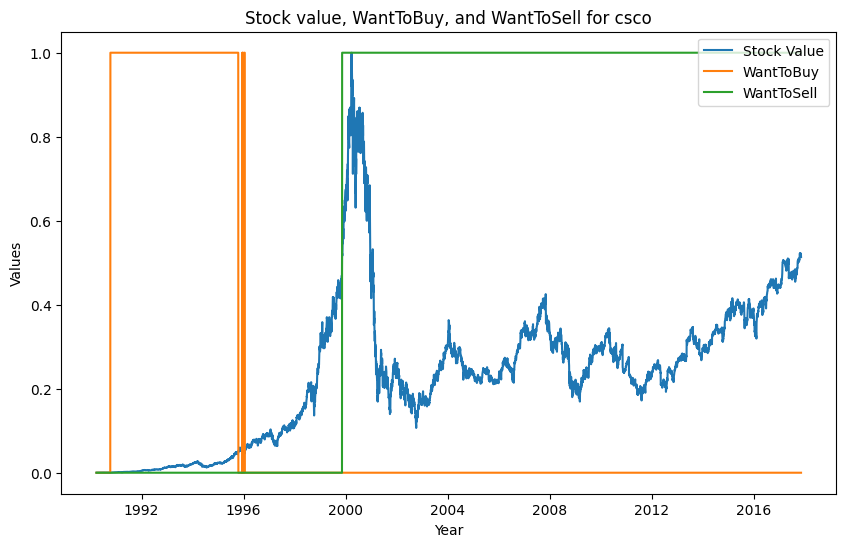

In [10]:
some_stock = stocks_df.query("Name == 'csco'")
#some_stock = stocks_df.query("Name == 'amzn'")

time = pd.to_datetime((some_stock.index.map(lambda x: x[0])))
stock_percentage_increase = some_stock['PercentageIncrease'].values
stock_want_to_buy = some_stock['WantToBuy'].values
stock_want_to_sell = some_stock['WantToSell'].values
plt.figure(figsize=(10, 6))
sns.lineplot(x=time, y=stock_percentage_increase, label='Stock Value')
sns.lineplot(x=time, y=stock_want_to_buy, label='WantToBuy')
sns.lineplot(x=time, y=stock_want_to_sell, label='WantToSell')

plt.title("Stock value, WantToBuy, and WantToSell for csco")
plt.xlabel("Year")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.show()

Επειδή η στρατηγική μας απαιτεί μεγάλο όγκο συναλλαγών, κυρίως λόγω του intraday-trading, στο οποίο πουλάμε και αγοράζουμε πίσω όσες περισσότερες μετοχές μπορούμε, για το μικρό παράδειγμα χρησιμοποιούμε μόνο δύο μετοχές "csco", "amzn". 

Για να περιορίσουμε το πλήθος των συναλλαγών, περιορίζουμε τις μέρες που αξίζει να κάνουμε intraday-trading, στις πρώτες 500 με το μεγαλύτερο μέτρο (High - Low) * Volume / Low. Το μέτρο αυτό ευνοεί τα υψηλά κέρδη intraday-trading, αλλά τιμωρεί όταν το Low είναι επίσης υψηλό. Η ιδέα είναι ότι επιλέγουμε να κάνουμε intraday-trading κυρίως στο early game που τα Low είναι χαμηλά, ενώ στο late game μας αρκεί η stonk φύση των μετοχών.

Τις μέρες που δεν αξίζει να κάνουμε intraday-trading, τις αφήνουμε ως έχουν.

Επίσης, για να περιορίσουμε ακόμα περισσότερο το πλήθος των συναλλαγών, τροποιούμε τη λόγικη με την οποία επιλέγουμε να κάνουμε intraday-trading. Συγκεκριμένα, κάνουμε intraday-trading το πολύ μία μετοχή (αυτή που θα δώσει το μεγαλύτερο κέρδος) για το sell open - rebuy low και το πολύ μια μετοχή για το sell high - rebuy close και μόνο όταν δεν έχουμε χρήματα να αγοράσουμε καμία μετοχή. Δίνουμε δλδ προτεραιότητα στην αγορά, αντί για το intraday, σε αντίθεση με τη large εκδοχή που θα δούμε παρακάτω. 


In [11]:
# small: csco, amzn
companies_bool = stocks_df.index.get_level_values("Name").isin(["csco", "amzn"])
intraday_bool = (
    (stocks_df["High"] == stocks_df["Open"]) | (stocks_df["Close"] == stocks_df["Low"])
) & (stocks_df["High"] > stocks_df["Low"])


intraday = stocks_df[companies_bool & intraday_bool].copy()
intraday["Gain"] = (
    (intraday["High"] - intraday["Low"]) * intraday["Volume"] / intraday["Low"] 
)
intraday_index = intraday.sort_values("Gain", ascending=False).head(500).index

# run it
portfolio = Portfolio()
trader = Trader(
    stocks_df.loc[
        ((companies_bool) & (~intraday_bool)) | stocks_df.index.isin(intraday_index)
    ],
    portfolio,
)
trader.trade("small")

# Results
print(f'Balance: {portfolio.balance}') # 7443360302.880279
print(f'Stock left: {portfolio.get_stocks()}') # 0 in stocks

# write file
write_transaction_file('../small.txt', portfolio.transaction_history) 


Balance: 7443360302.880279
Stock left: {}


Καταλήγουμε να έχουμε 7443360302.880279 (7.4δις) με 935 συναλλαγές και καθόλου περίσσιες μετοχές. Τα διαγράμματα δείχνουν την εξέλιξη του υπολοίπου καθώς και της αξίας των μετοχών που έχουμε στη διάθεσή μας.

In [12]:
money, stocks, both = plot_transaction_history(stocks_df, portfolio.transaction_history)
print(f"Stock value: {stocks[list(stocks.keys())[-1]]}, that I couldn't sell in time")

Stock value: 0, that I couldn't sell in time


<Axes: title={'center': 'Balance'}, xlabel='Year', ylabel='Balance($)'>

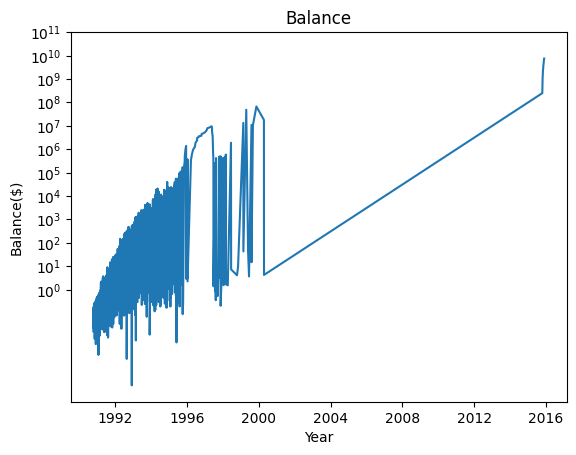

In [13]:
money_to_plot = pd.Series(list(money.values()), index=pd.to_datetime(list(money.keys())))
money_plot = sns.lineplot(money_to_plot)
money_plot.set_yscale("log")
money_plot.set_yticks(np.logspace(0, 11, num=12))
money_plot.set_title("Balance")
money_plot.set_xlabel("Year")
money_plot.set_ylabel("Balance($)")
money_plot

<Axes: title={'center': 'Stock value'}, xlabel='Year', ylabel='Portfolio Stock Value($)'>

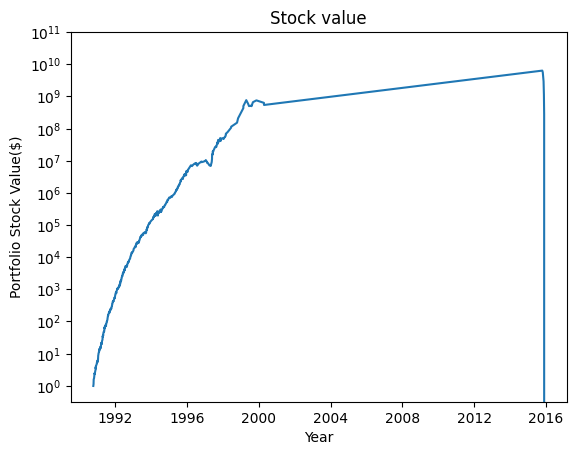

In [14]:
stock_to_plot = pd.Series(list(stocks.values()), index=pd.to_datetime(list(stocks.keys())))
stock_plot = sns.lineplot(stock_to_plot)
stock_plot.set_yscale("log")
stock_plot.set_yticks(np.logspace(0, 11, num=12))
stock_plot.set_title("Stock value")
stock_plot.set_xlabel("Year")
stock_plot.set_ylabel("Portfolio Stock Value($)")
stock_plot

Για το μεγάλο παράδειγμα, χρησιμοποιούμε και τις 50 stonk μετοχές. Τις μέρες που υπάρχει ευκαιρία κέρδους από το intraday-trading, επιλέγουμε να κάνουμε αυτό παρά να αγοράσουμε μια μετοχή. Επίσης όταν κάνουμε intraday trading πουλάμε όλες τις μετοχές μας και τις ξαναγοράζουμε όλες. Όταν έχουμε συγκεντρώσει τόσες πολλές μονάδες από μια μετοχή ώστε δεν μπορούμε να τις πουλήσουμε μέχρι το τέλος του χρονικού ορίζοντα, ξεκινάμε να πουλάμε αυτή τη μετοχή μαζικά.


In [15]:
# large: all the companies
# run it
portfolio = Portfolio()
trader = Trader(stocks_df, portfolio)
trader.trade()

# Results
print(f'Balance: {portfolio.balance}') # 1375651421015.0146$
print(f'Stock left: {portfolio.get_stocks()}') # 1150126535.21 in stock

# write file
write_transaction_file('../large.txt', portfolio.transaction_history) 

Balance: 1375651421015.0146
Stock left: {'mo': 5051777, 'aet': 144044, 'adbe': 146181, 'rost': 791892, 'aapl': 3507311, 'unh': 195366, 'gild': 627498, 'amzn': 15682}


Καταλήγουμε να έχουμε 1375651421015.0146 σε χρήματα (1.3 τρις) με 226147 συναλλαγές καθώς και 1150126535.21 (1.1δις) σε μετοχές που δεν προλάβαμε να πουλήσουμε. Τα διαγράμματα δείχνουν την εξέλιξη του υπολοίπου καθώς και της αξίας των μετοχών που έχουμε στη διάθεσή μας.

In [16]:
money, stocks, both = plot_transaction_history(stocks_df, portfolio.transaction_history)
print(f"Stock value: {stocks[list(stocks.keys())[-1]]}, that I couldn't sell in time")

Stock value: 1150126535.21, that I couldn't sell in time


<Axes: title={'center': 'Balance'}, xlabel='Year', ylabel='Balance($)'>

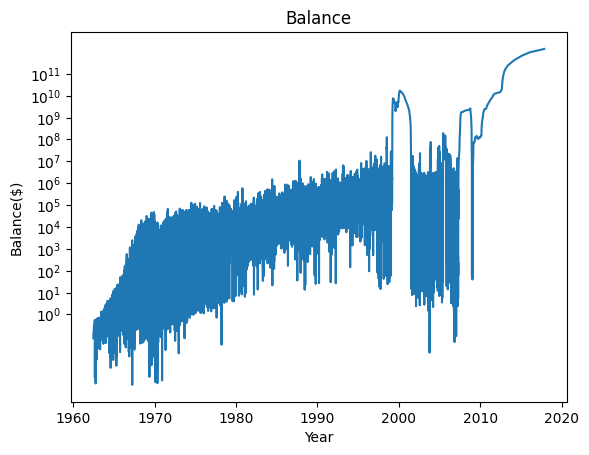

In [17]:
money_to_plot = pd.Series(list(money.values()), index=pd.to_datetime(list(money.keys())))
money_plot = sns.lineplot(money_to_plot)
money_plot.set_yscale("log")
money_plot.set_yticks(np.logspace(0, 11, num=12))
money_plot.set_title("Balance")
money_plot.set_xlabel("Year")
money_plot.set_ylabel("Balance($)")
money_plot

<Axes: title={'center': 'Stock value'}, xlabel='Year', ylabel='Portfolio Stock Value($)'>

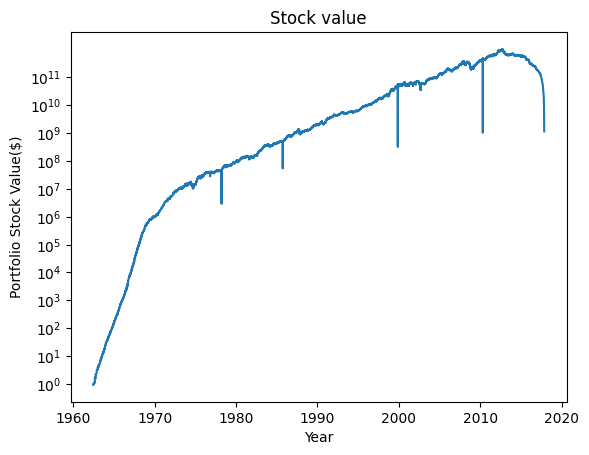

In [18]:
stock_to_plot = pd.Series(list(stocks.values()), index=pd.to_datetime(list(stocks.keys())))
stock_plot = sns.lineplot(stock_to_plot)
stock_plot.set_yscale("log")
stock_plot.set_yticks(np.logspace(0, 11, num=12))
stock_plot.set_title("Stock value")
stock_plot.set_xlabel("Year")
stock_plot.set_ylabel("Portfolio Stock Value($)")
stock_plot